# VEHICLE IMAGE CLASSIFICATION

I am Rishabh Jain and this is my take on how to classify vehicles using ResNet18



### STEP 1:
Importing the necessry standard libraries

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import matplotlib.pyplot as plt
import os
import numpy as np

### STEP 2:
Getting the data, processing it and loading it

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split,DataLoader

#trabsform functions composed
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

#full dataset
totaldata = ImageFolder(root = "/kaggle/input/vehicle-classification/Vehicles" , transform = transform)

#sizes
totalsize = len(totaldata)
trainsize = int(0.7*totalsize)
devsize = int(0.15*totalsize)
testsize=totalsize-trainsize-devsize

#actual splitting
traindata,devdata,testdata = random_split(totaldata,[trainsize,devsize,testsize])

#loading data
trainloader = DataLoader(traindata, batch_size=32, shuffle=True)
devloader = DataLoader(devdata, batch_size=32, shuffle=False) # shuffling is false as we are not training the dat on these sets
testloader = DataLoader(testdata, batch_size=32, shuffle=False)


### STEP 3:
Importing ResNet18 and changing its final layer

In [3]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.fc = nn.Linear(model.fc.in_features, 7)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s] 


### STEP 4:
Setting the optimizer and the loss function and code of the model training

In [4]:
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001) #only doing optimization on fully connected layer
lossfn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train(model, trainloader, devloader, lossfn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        trainloss = 0.0
        traincorrect = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfn(outputs, labels)
            loss.backward()
            optimizer.step()
            trainloss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            traincorrect += (predicted == labels).sum().item()

        avgtrainloss = trainloss / trainsize
        trainacc = traincorrect / trainsize

        model.eval()
        devloss = 0.0
        devcorrect = 0

        with torch.no_grad():
            for inputs, labels in devloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = lossfn(outputs, labels)
                devloss += loss.item()*inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                devcorrect += (predicted == labels).sum().item()

        avgdevloss = devloss / devsize
        devacc = devcorrect / devsize

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avgtrainloss:.4f} , Train Acc: {trainacc:.4f} , Dev Loss: {avgdevloss:.4f} , Dev Acc: {devacc:.4f}")


### STEP 5:
Train the model

In [5]:
train(model, trainloader, devloader, lossfn, optimizer, num_epochs = 5)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Train Loss: 0.5367 , Train Acc: 0.8829 , Dev Loss: 0.1740 , Dev Acc: 0.9737
Epoch 2/5, Train Loss: 0.1689 , Train Acc: 0.9619 , Dev Loss: 0.1127 , Dev Acc: 0.9761
Epoch 3/5, Train Loss: 0.1226 , Train Acc: 0.9703 , Dev Loss: 0.1024 , Dev Acc: 0.9761
Epoch 4/5, Train Loss: 0.1009 , Train Acc: 0.9755 , Dev Loss: 0.0762 , Dev Acc: 0.9809
Epoch 5/5, Train Loss: 0.0804 , Train Acc: 0.9798 , Dev Loss: 0.0703 , Dev Acc: 0.9797


### STEP 6:
Test the model

In [6]:
def testmodel(model,testloader,lossfn,device):

  model.eval()
  testloss = 0.0
  testcorrect = 0
  with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = lossfn(outputs, labels)
                testloss += loss.item()*inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                testcorrect += (predicted == labels).sum().item()


  avgtestloss = testloss / testsize
  testacc = testcorrect / testsize

  print(f"Final Loss: {avgtestloss:.4f} , Final Accuracy: {testacc:.4f}")


### STEP 7:
Show predictions of some images 

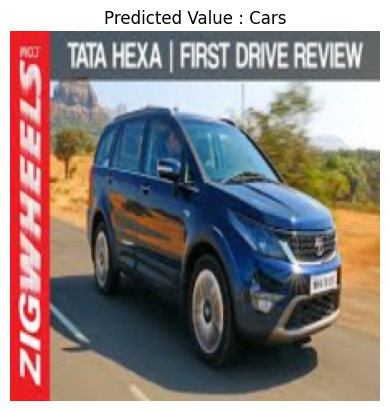

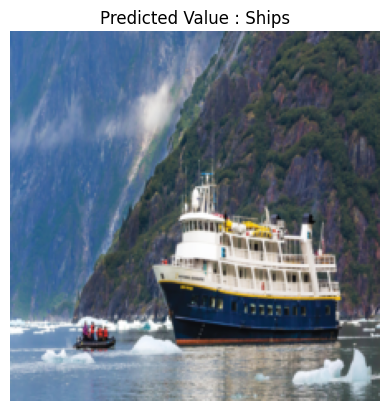

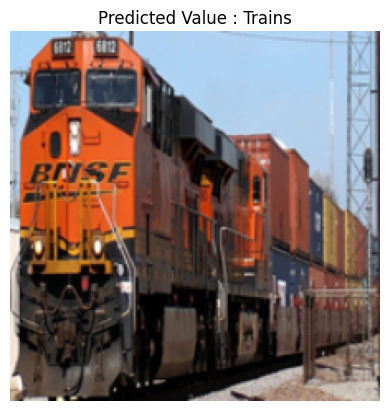

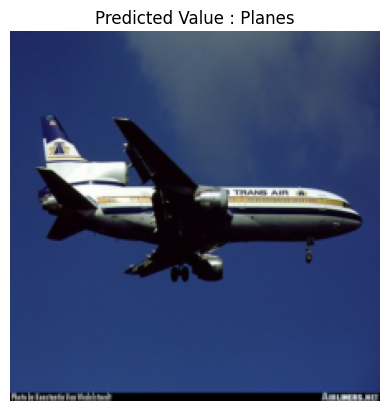

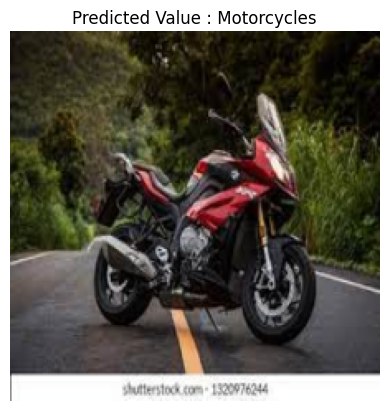

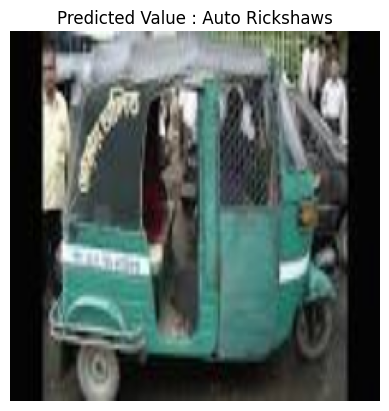

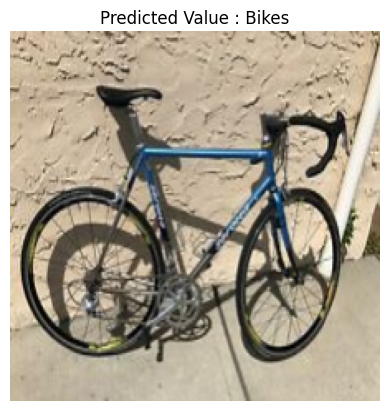

In [8]:
classnames = totaldata.classes

def imageshow(img, title):
    img = img.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])  
    std = np.array([0.229, 0.224, 0.225])  
    img = std * img + mean  
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_predictions(model, testloader, classnames, device):
    model.eval()
    
    seenclasses = set()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label not in seenclasses:
                    seenclasses.add(label)
                    imageshow(inputs[i].cpu(), f"Predicted Value : {classnames[pred]}")
                
                if len(seenclasses) == len(classnames):
                    return  

show_predictions(model, testloader, classnames, device)
